# 周期性を考慮
月日データの追加

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import japanize_matplotlib

In [2]:
def root_mean_squared_error(y_pred, y_test):
    return mean_squared_error(y_pred, y_test)**(1/2)

In [3]:
df_raw = pd.read_csv("../data/kk.csv")
# 全体のみを利用(産地名NaN)
is_nan = [df_raw["産地名"][i] is df_raw["産地名"][0] for i in range(df_raw.shape[0])]
df = df_raw[is_nan].copy()
del_columns = ["産地名", "産地コード", "品目名", "品目コード", "対前日比（数量）", "対前日比（価格）"]
df = df.drop(del_columns, axis=1).copy()


In [4]:
# 曜日の処理
dow = ["月", "火", "水", "木", "金", "土", "日"]
df["曜日"] = [dow.index(dw) for dw in df["曜日"]]


In [5]:
# 日にちの処理
# timestamp型 → timedelta
# date_columns = ["年", "月", "日"]
date = [str(df["年"].iloc[i])+"-"+str(df["月"].iloc[i])+"-" +
        str(df["日"].iloc[i]) for i in range(df.shape[0])]
df["date"] = pd.to_datetime(date)
# df = df.drop(date_columns, axis=1).copy()
df["days"] = [(date - df["date"][0]).days for date in df["date"]]
df = df.drop("date", axis=1).copy()


In [6]:
# 特異日 (天皇即位)
outlier = df[df["価格"].max() == df["価格"]].index 
# df = df.drop(outlier, axis=0).copy()

In [7]:
# 数量で重み付け
def ma_weighted(price, df):
    """
    Args:
        price (df.rolling): df.rolling.apply()を想定した価格列
        df: 重み列を取るための元df
    return:
        ma_w = 数量加重移動平均
    """

    df_price = df.loc[price.index, '価格']
    df_num = df.loc[price.index, '数量']
    
    ma_w = 0
    for p, n in zip(df_price, df_num):
        ma_w += n * p/df_num.sum()

    return ma_w


In [8]:
ma_w3 = df["価格"].rolling(3).apply(ma_weighted, args=(df,), raw=False)
ma_w5 = df["価格"].rolling(5).apply(ma_weighted, args=(df,), raw=False)
ma_w7 = df["価格"].rolling(7).apply(ma_weighted, args=(df,), raw=False)


In [9]:
# train-test-split
# 7年分をtrain，3年分をtest(index 9426以上)
ma_w5 = ma_w5.dropna()
df_train = ma_w5[ma_w5.index < 9426].copy()
df_test = ma_w5[ma_w5.index >= 9426].copy()


In [10]:
df[df.index < 9426]

,年,月,日,曜日,数量,価格,days
0,2012,1,5,3,840793,1525,0
4,2012,1,6,4,528012,1377,1
8,2012,1,7,5,317676,1292,2
12,2012,1,9,0,667,1466,4
15,2012,1,10,1,549611,1234,5
...,...,...,...,...,...,...,...
9397,2018,12,26,2,221658,2048,2547
9403,2018,12,27,3,271452,2010,2548
9409,2018,12,28,4,252370,1945,2549
9415,2018,12,29,5,293986,1934,2550


In [11]:
date_train_raw = df.loc[df_train.index, ["年", "月", "日", "曜日"]].copy()
date_test_raw = df.loc[df_test.index, ["年", "月", "日", "曜日"]].copy()

In [12]:
# 学習データ作成
n_train = df_train.shape[0] - 7 - 6
X_train_idx = [np.array([0, 1, 2, 3, 4, 5, 6]) + i for i in range(n_train)]
y_train_idx = [i + 7 + 6 for i in range(n_train)]

date_train_idx = [i + 6 for i in range(n_train)]

n_test = df_test.shape[0] - 7 - 6
X_test_idx = [np.array([0, 1, 2, 3, 4, 5, 6]) + i for i in range(n_test)]
y_test_idx = [i + 7 + 6 for i in range(n_test)]

date_test_idx = [i + 6 for i in range(n_test)]

X_train = np.array([df_train.iloc[xt_i].values for xt_i in X_train_idx])

y_train = np.array([df_train.iloc[yt_i] for yt_i in y_train_idx])

X_test = np.array([df_test.iloc[xt_i].values for xt_i in X_test_idx])
y_test = np.array([df_test.iloc[yt_i] for yt_i in y_test_idx])

In [13]:
X_train = pd.DataFrame(X_train, columns=np.arange(7))
X_test = pd.DataFrame(X_test, columns=np.arange(7))
y_train = pd.Series(y_train)
y_test = pd.Series(y_test)

In [14]:
date_train = date_train_raw.iloc[date_train_idx].reset_index(drop=True)
date_test = date_test_raw.iloc[date_test_idx].reset_index(drop=True)

In [15]:
X_train = pd.concat([X_train, date_train], axis=1)
X_test = pd.concat([X_test, date_test], axis=1)

In [16]:
import lightgbm as lgb

model = lgb.LGBMRegressor(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

score = root_mean_squared_error(y_pred, y_test)
print(score)

ape = sum(abs((y_test-y_pred)/y_test))
mape = ape/y_test.shape[0]
print(mape)

187.275739116027
0.06050149909514425


Text(0.5, 1.0, '市場価格5日移動平均の予測')

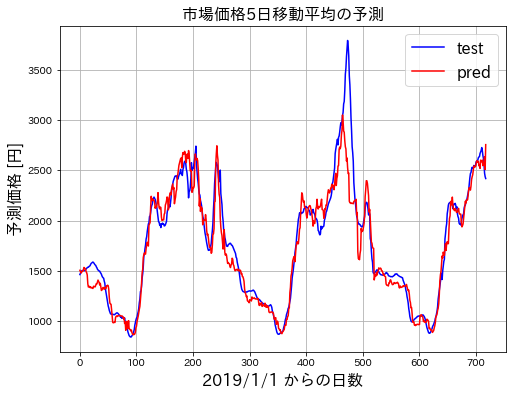

In [17]:
fig, ax = plt.subplots()
ax.grid()
fig.set_figwidth(8)
fig.set_figheight(6)

ax.plot(np.arange(y_test.shape[0]), y_test, "b", label="test")
ax.plot(np.arange(y_pred.shape[0]), y_pred, "r", label="pred")
ax.legend(fontsize=16)
ax.set_xlabel("2019/1/1 からの日数", fontsize=16)
ax.set_ylabel("予測価格 [円]", fontsize=16)
ax.set_title("市場価格5日移動平均の予測", fontsize=16)

# 移動平均なしでの予測

In [18]:
# train-test-split
# 7年分をtrain，3年分をtest(index 9426以上)
df = df.drop(outlier, axis=0).copy()
df_train = df["価格"][df.index < 9426].copy()
df_test = df["価格"][df.index >= 9426].copy()


In [20]:
date_train_raw = df.loc[df_train.index, ["年", "月", "日", "曜日"]].copy()
date_test_raw = df.loc[df_test.index, ["年", "月", "日", "曜日"]].copy()

In [21]:
# 学習データ作成
n_train = df_train.shape[0] - 7 - 6
X_train_idx = [np.array([0, 1, 2, 3, 4, 5, 6]) + i for i in range(n_train)]
y_train_idx = [i + 7 + 6 for i in range(n_train)]

date_train_idx = [i + 6 for i in range(n_train)]

n_test = df_test.shape[0] - 7 - 6
X_test_idx = [np.array([0, 1, 2, 3, 4, 5, 6]) + i for i in range(n_test)]
y_test_idx = [i + 7 + 6 for i in range(n_test)]

date_test_idx = [i + 6 for i in range(n_test)]

X_train = np.array([df_train.iloc[xt_i].values for xt_i in X_train_idx])

y_train = np.array([df_train.iloc[yt_i] for yt_i in y_train_idx])

X_test = np.array([df_test.iloc[xt_i].values for xt_i in X_test_idx])
y_test = np.array([df_test.iloc[yt_i] for yt_i in y_test_idx])

In [22]:
X_train = pd.DataFrame(X_train, columns=np.arange(7))
X_test = pd.DataFrame(X_test, columns=np.arange(7))
y_train = pd.Series(y_train)
y_test = pd.Series(y_test)

In [23]:
date_train = date_train_raw.iloc[date_train_idx].reset_index(drop=True)
date_test = date_test_raw.iloc[date_test_idx].reset_index(drop=True)

In [24]:
X_train = pd.concat([X_train, date_train], axis=1)
X_test = pd.concat([X_test, date_test], axis=1)

In [25]:
import lightgbm as lgb

model = lgb.LGBMRegressor(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

score = root_mean_squared_error(y_pred, y_test)
print(score)

ape = sum(abs((y_test-y_pred)/y_test))
mape = ape/y_test.shape[0]
print(mape)

232.5688917677162
0.0732281898543516


Text(0.5, 1.0, '市場価格の予測')

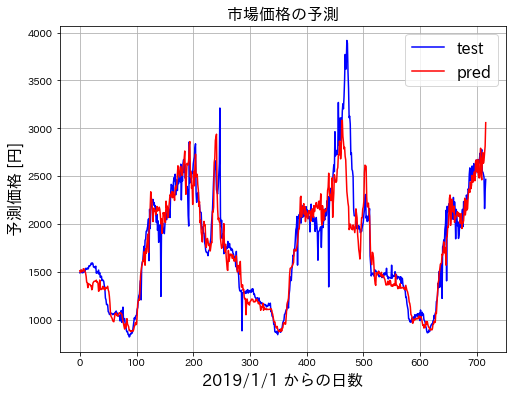

In [26]:
fig, ax = plt.subplots()
ax.grid()
fig.set_figwidth(8)
fig.set_figheight(6)

ax.plot(np.arange(y_test.shape[0]), y_test, "b", label="test")
ax.plot(np.arange(y_pred.shape[0]), y_pred, "r", label="pred")
ax.legend(fontsize=16)
ax.set_xlabel("2019/1/1 からの日数", fontsize=16)
ax.set_ylabel("予測価格 [円]", fontsize=16)
ax.set_title("市場価格の予測", fontsize=16)

# Optuna 利用
 

In [27]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

# ベストなパラメータ、途中経過を保存する
params = {
    'objective': 'regression',
    'metric': 'mape',
    "verbosity": -1,
    "boosting_type": "gbdt",
}

best_params, history = {}, []

# LightGBM学習
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=200,
                valid_sets=[lgb_train, lgb_eval],
                early_stopping_rounds=50
               )

best_params = gbm.params
best_params

[1]	training's mape: 0.336922	valid_1's mape: 0.349139
Training until validation scores don't improve for 50 rounds
[2]	training's mape: 0.306245	valid_1's mape: 0.319122
[3]	training's mape: 0.2784	valid_1's mape: 0.291028
[4]	training's mape: 0.253337	valid_1's mape: 0.267013
[5]	training's mape: 0.230987	valid_1's mape: 0.244931
[6]	training's mape: 0.211092	valid_1's mape: 0.225053
[7]	training's mape: 0.193361	valid_1's mape: 0.207374
[8]	training's mape: 0.177618	valid_1's mape: 0.191148
[9]	training's mape: 0.163521	valid_1's mape: 0.17694
[10]	training's mape: 0.150937	valid_1's mape: 0.163974
[11]	training's mape: 0.139599	valid_1's mape: 0.152804
[12]	training's mape: 0.129491	valid_1's mape: 0.142314
[13]	training's mape: 0.120597	valid_1's mape: 0.133224
[14]	training's mape: 0.112465	valid_1's mape: 0.125345
[15]	training's mape: 0.105424	valid_1's mape: 0.118556
[16]	training's mape: 0.0991337	valid_1's mape: 0.112522
[17]	training's mape: 0.093571	valid_1's mape: 0.1068


{'objective': 'regression',
 'metric': 'mape',
 'verbosity': -1,
 'boosting_type': 'gbdt',
 'num_iterations': 200,
 'early_stopping_round': 50}

In [28]:
y_pred=gbm.predict(X_test, num_iteration=gbm.best_iteration)
score = root_mean_squared_error(y_pred, y_test)
print(score)

ape = sum(abs((y_test-y_pred)/y_test))
mape = ape/y_test.shape[0]
print(1-mape)

239.1630155780309
0.9242381670843195


In [29]:
y_pred=gbm.predict(X_test, num_iteration=gbm.best_iteration)
score = root_mean_squared_error(y_pred, y_test)
print(score)

ape = sum(abs((y_test-y_pred)/y_test))
mape = ape/y_test.shape[0]
print(1-mape)

239.1630155780309
0.9242381670843195


Text(0.5, 1.0, '市場価格5日移動平均の予測')

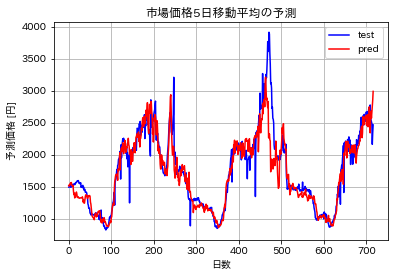

<Figure size 432x576 with 0 Axes>

In [30]:
fig, ax = plt.subplots()
plt.figure(figsize=(6, 8))

ax.grid()

ax.plot(np.arange(y_test.shape[0]), y_test, "b", label="test")
ax.plot(np.arange(y_pred.shape[0]), y_pred, "r", label="pred")
ax.legend()
ax.set_xlabel("日数")
ax.set_ylabel("予測価格 [円]")
ax.set_title("市場価格5日移動平均の予測")


# get_dummies

In [138]:
df_raw = pd.read_csv("../data/kk.csv")
# 全体のみを利用(産地名NaN)
is_nan = [df_raw["産地名"][i] is df_raw["産地名"][0] for i in range(df_raw.shape[0])]
df = df_raw[is_nan].copy()
del_columns = ["産地名", "産地コード", "品目名", "品目コード", "対前日比（数量）", "対前日比（価格）"]
df = df.drop(del_columns, axis=1).copy()


In [139]:
# 曜日の処理
dow = ["月", "火", "水", "木", "金", "土", "日"]
df["曜日"] = [dow.index(dw) for dw in df["曜日"]]

In [140]:
# 日にちの処理
# timestamp型 → timedelta
# date_columns = ["年", "月", "日"]
date = [str(df["年"].iloc[i])+"-"+str(df["月"].iloc[i])+"-" +
        str(df["日"].iloc[i]) for i in range(df.shape[0])]
df["date"] = pd.to_datetime(date)
# df = df.drop(date_columns, axis=1).copy()
df["days"] = [(date - df["date"][0]).days for date in df["date"]]
df = df.drop("date", axis=1).copy()


In [141]:
# 特異日 (天皇即位)
outlier = df[df["価格"].max() == df["価格"]].index 
# df = df.drop(outlier, axis=0).copy()

In [142]:
# 数量で重み付け
def ma_weighted(price, df):
    """
    Args:
        price (df.rolling): df.rolling.apply()を想定した価格列
        df: 重み列を取るための元df
    return:
        ma_w = 数量加重移動平均
    """

    df_price = df.loc[price.index, '価格']
    df_num = df.loc[price.index, '数量']
    
    ma_w = 0
    for p, n in zip(df_price, df_num):
        ma_w += n * p/df_num.sum()

    return ma_w


In [143]:
ma_w3 = df["価格"].rolling(3).apply(ma_weighted, args=(df,), raw=False)
ma_w5 = df["価格"].rolling(5).apply(ma_weighted, args=(df,), raw=False)
ma_w7 = df["価格"].rolling(7).apply(ma_weighted, args=(df,), raw=False)


In [144]:
# train-test-split
# 7年分をtrain，3年分をtest(index 9426以上)
ma_w5 = ma_w5.dropna()
df_train = ma_w5[ma_w5.index < 9426].copy()
df_test = ma_w5[ma_w5.index >= 9426].copy()


In [145]:
# one-hot
dowdf = pd.get_dummies(df["曜日"])
dowdf.columns = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
df = df.drop("曜日", axis=1).copy()
df = pd.concat([df, dowdf], axis=1)

In [146]:
date_columns = ["年", "月", "日"] + ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
date_train_raw = df.loc[df_train.index, date_columns].copy()
date_test_raw = df.loc[df_test.index, date_columns].copy()

In [147]:
# 学習データ作成
n_train = df_train.shape[0] - 7 - 6
X_train_idx = [np.array([0, 1, 2, 3, 4, 5, 6]) + i for i in range(n_train)]
y_train_idx = [i + 7 + 6 for i in range(n_train)]

date_train_idx = [i + 6 for i in range(n_train)]

n_test = df_test.shape[0] - 7 - 6
X_test_idx = [np.array([0, 1, 2, 3, 4, 5, 6]) + i for i in range(n_test)]
y_test_idx = [i + 7 + 6 for i in range(n_test)]

date_test_idx = [i + 6 for i in range(n_test)]

X_train = np.array([df_train.iloc[xt_i].values for xt_i in X_train_idx])

y_train = np.array([df_train.iloc[yt_i] for yt_i in y_train_idx])

X_test = np.array([df_test.iloc[xt_i].values for xt_i in X_test_idx])
y_test = np.array([df_test.iloc[yt_i] for yt_i in y_test_idx])

In [148]:
X_train = pd.DataFrame(X_train, columns=np.arange(7))
X_test = pd.DataFrame(X_test, columns=np.arange(7))
y_train = pd.Series(y_train)
y_test = pd.Series(y_test)

In [149]:
date_train = date_train_raw.iloc[date_train_idx].reset_index(drop=True)
date_test = date_test_raw.iloc[date_test_idx].reset_index(drop=True)

In [150]:
X_train = pd.concat([X_train, date_train], axis=1)
X_test = pd.concat([X_test, date_test], axis=1)

In [151]:
import lightgbm as lgb

model = lgb.LGBMRegressor(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

score = root_mean_squared_error(y_pred, y_test)
print(score)

ape = sum(abs((y_test-y_pred)/y_test))
mape = ape/y_test.shape[0]
print(mape)

188.19902625812944
0.06017255091682741


Text(0.5, 1.0, '市場価格5日移動平均の予測')

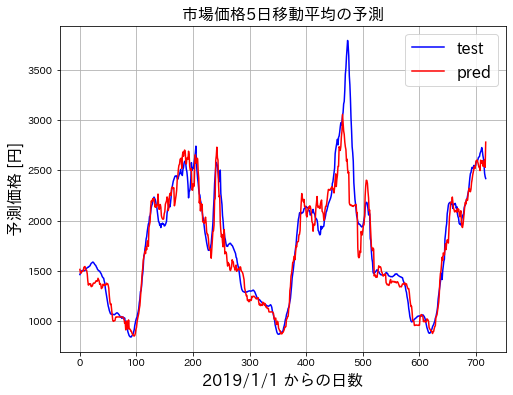

In [152]:
fig, ax = plt.subplots()
ax.grid()
fig.set_figwidth(8)
fig.set_figheight(6)

ax.plot(np.arange(y_test.shape[0]), y_test, "b", label="test")
ax.plot(np.arange(y_pred.shape[0]), y_pred, "r", label="pred")
ax.legend(fontsize=16)
ax.set_xlabel("2019/1/1 からの日数", fontsize=16)
ax.set_ylabel("予測価格 [円]", fontsize=16)
ax.set_title("市場価格5日移動平均の予測", fontsize=16)

In [153]:
# train-test-split
# 7年分をtrain，3年分をtest(index 9426以上)
df = df.drop(outlier, axis=0).copy()
df_train = df["価格"][df.index < 9426].copy()
df_test = df["価格"][df.index >= 9426].copy()


In [154]:
date_columns = ["年", "月", "日"] + ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
date_train_raw = df.loc[df_train.index, date_columns].copy()
date_test_raw = df.loc[df_test.index, date_columns].copy()

In [155]:
# 学習データ作成
n_train = df_train.shape[0] - 7 - 6
X_train_idx = [np.array([0, 1, 2, 3, 4, 5, 6]) + i for i in range(n_train)]
y_train_idx = [i + 7 + 6 for i in range(n_train)]

date_train_idx = [i + 6 for i in range(n_train)]

n_test = df_test.shape[0] - 7 - 6
X_test_idx = [np.array([0, 1, 2, 3, 4, 5, 6]) + i for i in range(n_test)]
y_test_idx = [i + 7 + 6 for i in range(n_test)]

date_test_idx = [i + 6 for i in range(n_test)]

X_train = np.array([df_train.iloc[xt_i].values for xt_i in X_train_idx])

y_train = np.array([df_train.iloc[yt_i] for yt_i in y_train_idx])

X_test = np.array([df_test.iloc[xt_i].values for xt_i in X_test_idx])
y_test = np.array([df_test.iloc[yt_i] for yt_i in y_test_idx])

In [156]:
X_train = pd.DataFrame(X_train, columns=np.arange(7))
X_test = pd.DataFrame(X_test, columns=np.arange(7))
y_train = pd.Series(y_train)
y_test = pd.Series(y_test)

In [157]:
date_train = date_train_raw.iloc[date_train_idx].reset_index(drop=True)
date_test = date_test_raw.iloc[date_test_idx].reset_index(drop=True)

In [158]:
X_train = pd.concat([X_train, date_train], axis=1)
X_test = pd.concat([X_test, date_test], axis=1)

In [159]:
import lightgbm as lgb

model = lgb.LGBMRegressor(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

score = root_mean_squared_error(y_pred, y_test)
print(score)

ape = sum(abs((y_test-y_pred)/y_test))
mape = ape/y_test.shape[0]
print(mape)

234.00074933571264
0.07404154174990836


Text(0.5, 1.0, '市場価格の予測')

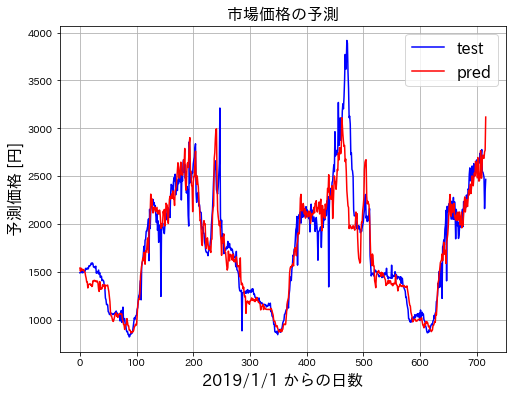

In [160]:
fig, ax = plt.subplots()
ax.grid()
fig.set_figwidth(8)
fig.set_figheight(6)

ax.plot(np.arange(y_test.shape[0]), y_test, "b", label="test")
ax.plot(np.arange(y_pred.shape[0]), y_pred, "r", label="pred")
ax.legend(fontsize=16)
ax.set_xlabel("2019/1/1 からの日数", fontsize=16)
ax.set_ylabel("予測価格 [円]", fontsize=16)
ax.set_title("市場価格の予測", fontsize=16)

one-hotはだめ

周期関数を通して日曜と月曜の関係を考慮させるとか？

# グラフ作成
あとで削除

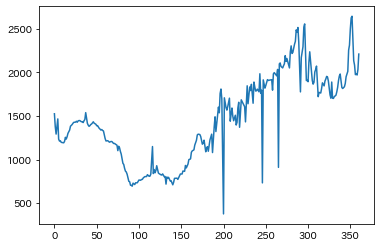

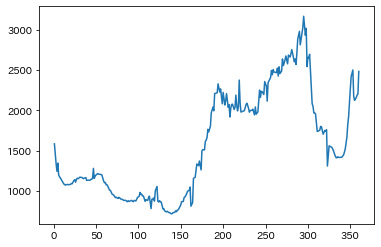

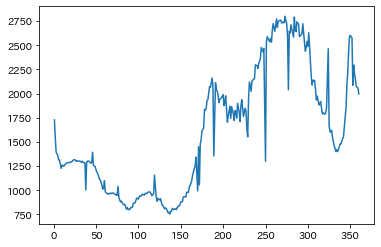

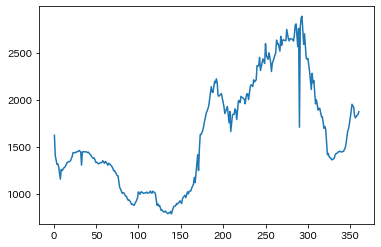

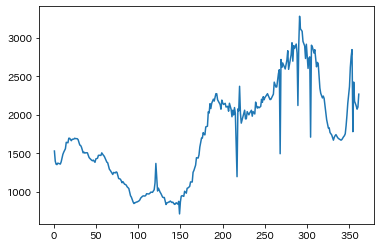

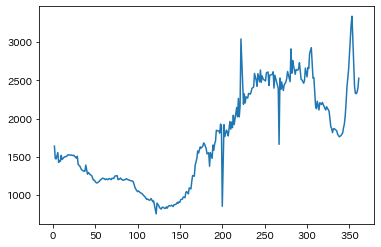

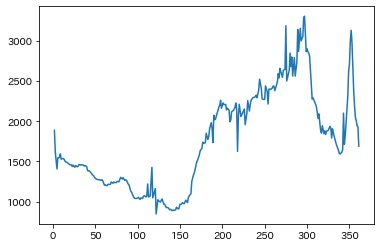

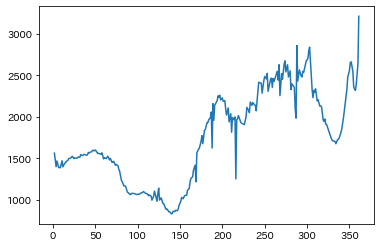

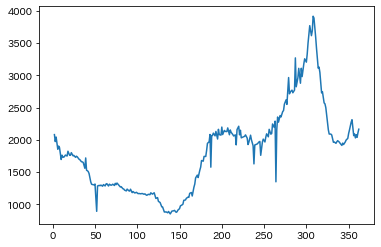

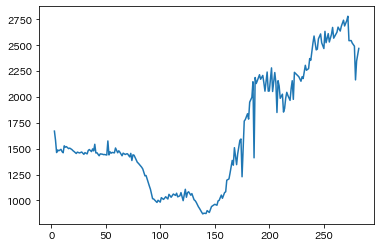

In [31]:
years = np.arange(10) + 2012
for year in years:
    df_year = df[df["年"] == year].copy()
    plt.plot(df_year["days"]-365*(year-2012), df_year["価格"])
    plt.show()

In [32]:
years = np.arange(10) + 2012
print("最大")
for year in years:
    df_year = df[df["年"] == year].copy()
    max_data = df_year[df_year["価格"] == df_year["価格"].max()]
    print(str(max_data["年"].values[0])+"/"+str(max_data["月"].values[0])+"/"+str(max_data["日"].values[0])+": "+str(max_data["価格"].values[0])+"円")

最大
2012/12/22: 2644円
2013/10/26: 3165円
2014/10/4: 2800円
2015/10/24: 2891円
2016/10/21: 3278円
2017/12/22: 3337円
2018/10/27: 3308円
2019/12/30: 3213円
2020/11/6: 3917円
2021/10/1: 2780円


In [33]:
max_idx = y_pred.argmax()

In [34]:
X_test

,0,1,2,3,4,5,6,年,月,日,曜日
0,1560,1397,1466,1386,1389,1384,1468,2019,1,14,0
1,1397,1466,1386,1389,1384,1468,1395,2019,1,15,1
2,1466,1386,1389,1384,1468,1395,1417,2019,1,16,2
3,1386,1389,1384,1468,1395,1417,1436,2019,1,17,3
4,1389,1384,1468,1395,1417,1436,1444,2019,1,18,4
...,...,...,...,...,...,...,...,...,...,...,...
712,2606,2672,2568,2626,2675,2637,2683,2021,9,25,5
713,2672,2568,2626,2675,2637,2683,2742,2021,9,27,0
714,2568,2626,2675,2637,2683,2742,2686,2021,9,28,1
715,2626,2675,2637,2683,2742,2686,2738,2021,9,30,3


In [35]:
importance = pd.DataFrame(model.feature_importances_, index=X_test.columns, columns=['importance'])
display(importance)

,importance
0,282
1,226
2,244
3,216
4,295
5,289
6,395
年,257
月,397
日,331


In [36]:
dir(model)

['_Booster',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_base_doc',
 '_best_iteration',
 '_best_score',
 '_check_n_features',
 '_class_map',
 '_class_weight',
 '_classes',
 '_estimator_type',
 '_evals_result',
 '_fobj',
 '_get_param_names',
 '_get_tags',
 '_more_tags',
 '_n_classes',
 '_n_features',
 '_n_features_in',
 '_objective',
 '_other_params',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_validate_data',
 'best_iteration_',
 'best_score_',
 'booster_',
 'boosting_type',
 'class_weight',
 'colsample_bytree',
 'evals_result_',
 'feature_importances_',
 'feature_name_',
 'fit',
 'fitted_',
 'get_params',
 'imp